In [1]:
import os
import h5py
import pycbc
import timeit
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

**Data Loder**

In [2]:
path = 'Data_20_100.h5'
# path = 'Data.h5'
n_t_data = 3000
n_v_data = 300
with h5py.File(path, 'r') as Data:
    training_strain = Data['Training_data/Strain'][:n_t_data]
    m_1 = Data['Training_data/Mass_1'][:n_t_data]
    m_2 = Data['Training_data/Mass_2'][:n_t_data]
    para = np.c_[m_1, m_2]
    validation_strain = Data['Validation_data/Strain'][:n_v_data]
    v_m_1 = Data['Validation_data/Mass_1'][:n_v_data]
    v_m_2 = Data['Validation_data/Mass_2'][:n_v_data]
    v_para = np.c_[v_m_1, v_m_2]
    test_strain = Data['Testing_data/Strain'][:8]
    t_m_1 = Data['Testing_data/Mass_1'][:8]
    t_m_2 = Data['Testing_data/Mass_2'][:8]
    t_para = np.c_[t_m_1, t_m_2]

In [3]:
class NNcAE():
    def __init__(self, sample_rate = 1024, para_meter_dims = 2):
        self.sample_rate = sample_rate
        self.para_meter_dims = para_meter_dims
        self.n_1_nodes = 6144
        self.n_2_nodes = 6144
        self.n_3_nodes = 768
        self.n_4_nodes = 224
        
        self.l_nodes = 32
        
        self.n_1_nodes_c = 5120
        self.n_2_nodes_c = 384
        self.n_3_nodes_c = 32

    def s_encoder(self):
        sr = layers.Input(shape = (self.sample_rate,), name = 'tar_strain')
        pa = layers.Input(shape = (self.para_meter_dims,), name = 'masses')
        y = layers.Concatenate()([sr, pa])
        y = layers.Reshape((self.sample_rate + self.para_meter_dims,))(y)
        y = layers.Dense(units = self.n_1_nodes, activation = 'linear')(y)
        y = layers.Dense(units = self.n_2_nodes, activation = 'tanh')(y)
        y = layers.Dense(units = self.n_3_nodes, activation = 'tanh')(y)
        y = layers.Dense(units = self.n_4_nodes, activation = 'tanh')(y)
        
        #Greetings! I am the zantent_vector_1.
        zantent_vector_1 = layers.Dense(units = self.l_nodes, activation = 'linear', name = 'zantent_vector_1')(y)
        
        model = Model([sr, pa], zantent_vector_1)
        return model
        
    def mapping(self):        
        pa = layers.Input(shape = (self.para_meter_dims,), name = 'm_masses')
        x = layers.Dense(units = self.n_1_nodes_c, activation = 'tanh')(pa)
        x = layers.Dense(units = self.n_2_nodes_c, activation = 'linear')(x)
        x = layers.Dense(units = self.n_3_nodes_c, activation = 'linear')(x)
        
        #Greetings! I am the zantent_vector_2.
        zantent_vector_2 = layers.Dense(units = self.l_nodes, activation = 'relu', name = 'zantent_vector_2')(x)
        
        model = Model(pa, zantent_vector_2, name = 'Mapping')
        return model
        
        
    def decoder(self):
        zantent_vector_2 = layers.Input(shape = (self.l_nodes,), name = 'lantent')
        pa = layers.Input(shape = (self.para_meter_dims,), name = 'd_mass')
        x = layers.Concatenate()([zantent_vector_2, pa])
        x = layers.Reshape((self.l_nodes + self.para_meter_dims,))(x)
        x = layers.Dense(units = self.n_4_nodes, activation = 'tanh')(x)
        x = layers.Dense(units = self.n_3_nodes, activation = 'relu')(x)
        x = layers.Dense(units = self.n_2_nodes, activation = 'relu')(x)
        x = layers.Dense(units = self.n_1_nodes, activation = 'tanh')(x)
        
        #Greetings! I am the Strain.
        strain = layers.Dense(units = self.sample_rate, activation = 'linear', name = 'Strain')(x)         
        
        
        model = Model([zantent_vector_2, pa], strain, name = 'Strain')
        return model
    
    def gym(self, training_strain, para, validation_strain, v_para, n_t_data, n_v_data, auto_training = True, batch_size = 500, epochs = 500, **kwargs):
        encoder = self.s_encoder()
        t_strain, mass = encoder.input
        zantent_vector_1 = encoder([t_strain, mass])
        
        mapper = self.mapping()
        zantent_vector_2 = mapper(mass)
        zantent_vector_2._name = 'zantent_vector_2'
        
        z_diff = keras.losses.mean_absolute_error(zantent_vector_1, zantent_vector_2)
        z_diff = layers.Reshape((1,), name = 'z_diff')(z_diff)
        
        decoding = self.decoder()
        
        strain = decoding([zantent_vector_2, mass])
        strain._name = 'Strain'
        print(strain)
        gym_model = Model([t_strain, mass], [z_diff, strain])
        print(gym_model)
        gym_model.compile(optimizer = 'Adam', 
                          loss = ['mean_absolute_error', 'mean_squared_error'],
                          metrics = ['accuracy']
                         )
        if auto_training:
            num = para.shape[0]
            zer0 = np.zeros(n_t_data).reshape([-1,1])
            ziro = np.zeros(n_v_data).reshape([-1,1])
            ghost = gym_model.fit(x = [training_strain, para], 
                                  y = [zer0, training_strain], 
                                  validation_data = ([validation_strain, v_para], 
                                                     [ziro, validation_strain]),
                                  batch_size = batch_size, epochs = epochs,)
            produtive_cAE = Model(mass, strain)
            produtive_cAE.save('Your_model.h5')
#             keras.utils.plot_model(produtive_cAE, 'produtive_cAE.png', show_shapes = True, dpi = 250)
            return produtive_cAE
        else:
            return gym_model

**Use Saved model**

In [4]:
# This helps u to train and save the generator model automaticlly
NNcAE().gym(training_strain, para, validation_strain, v_para, n_t_data, n_v_data, auto_training = True) 

KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='Strain', description="created by layer 'Strain'")
Epoch 1/500
6/6 [==============================] - 2s 122ms/step - loss: 0.7327 - z_diff_loss: 0.7229 - Strain_loss: 0.0098 - z_diff_accuracy: 0.5002 - Strain_accuracy: 0.0665 - val_loss: 0.3212 - val_z_diff_loss: 0.3125 - val_Strain_loss: 0.0087 - val_z_diff_accuracy: 1.0000 - val_Strain_accuracy: 0.1633
Epoch 2/500
6/6 [==============================] - 0s 20ms/step - loss: 0.2583 - z_diff_loss: 0.2498 - Strain_loss: 0.0085 - z_diff_accuracy: 1.0000 - Strain_accuracy: 0.1388 - val_loss: 0.1428 - val_z_diff_loss: 0.1349 - val_Strain_loss: 0.0079 - val_z_diff_accuracy: 1.0000 - val_Strain_accuracy: 0.1133
Epoch 3/500
6/6 [==============================] - 0s 19ms/step - loss: 0.1262 - z_diff_loss: 0.1182 - Strain_loss: 0.0080 - z_diff_accuracy: 0.9995 - Strain_accuracy: 0.1232 - val_loss: 0.0935 - val_z_diff_loss: 0.0860 - val_Strain_loss: 0.0076 - 

In [5]:
cAE_mini = tf.keras.models.load_model('Your_model.h5')
cAE_mini.compile()

In [6]:
jason = cAE_mini.predict(t_para)

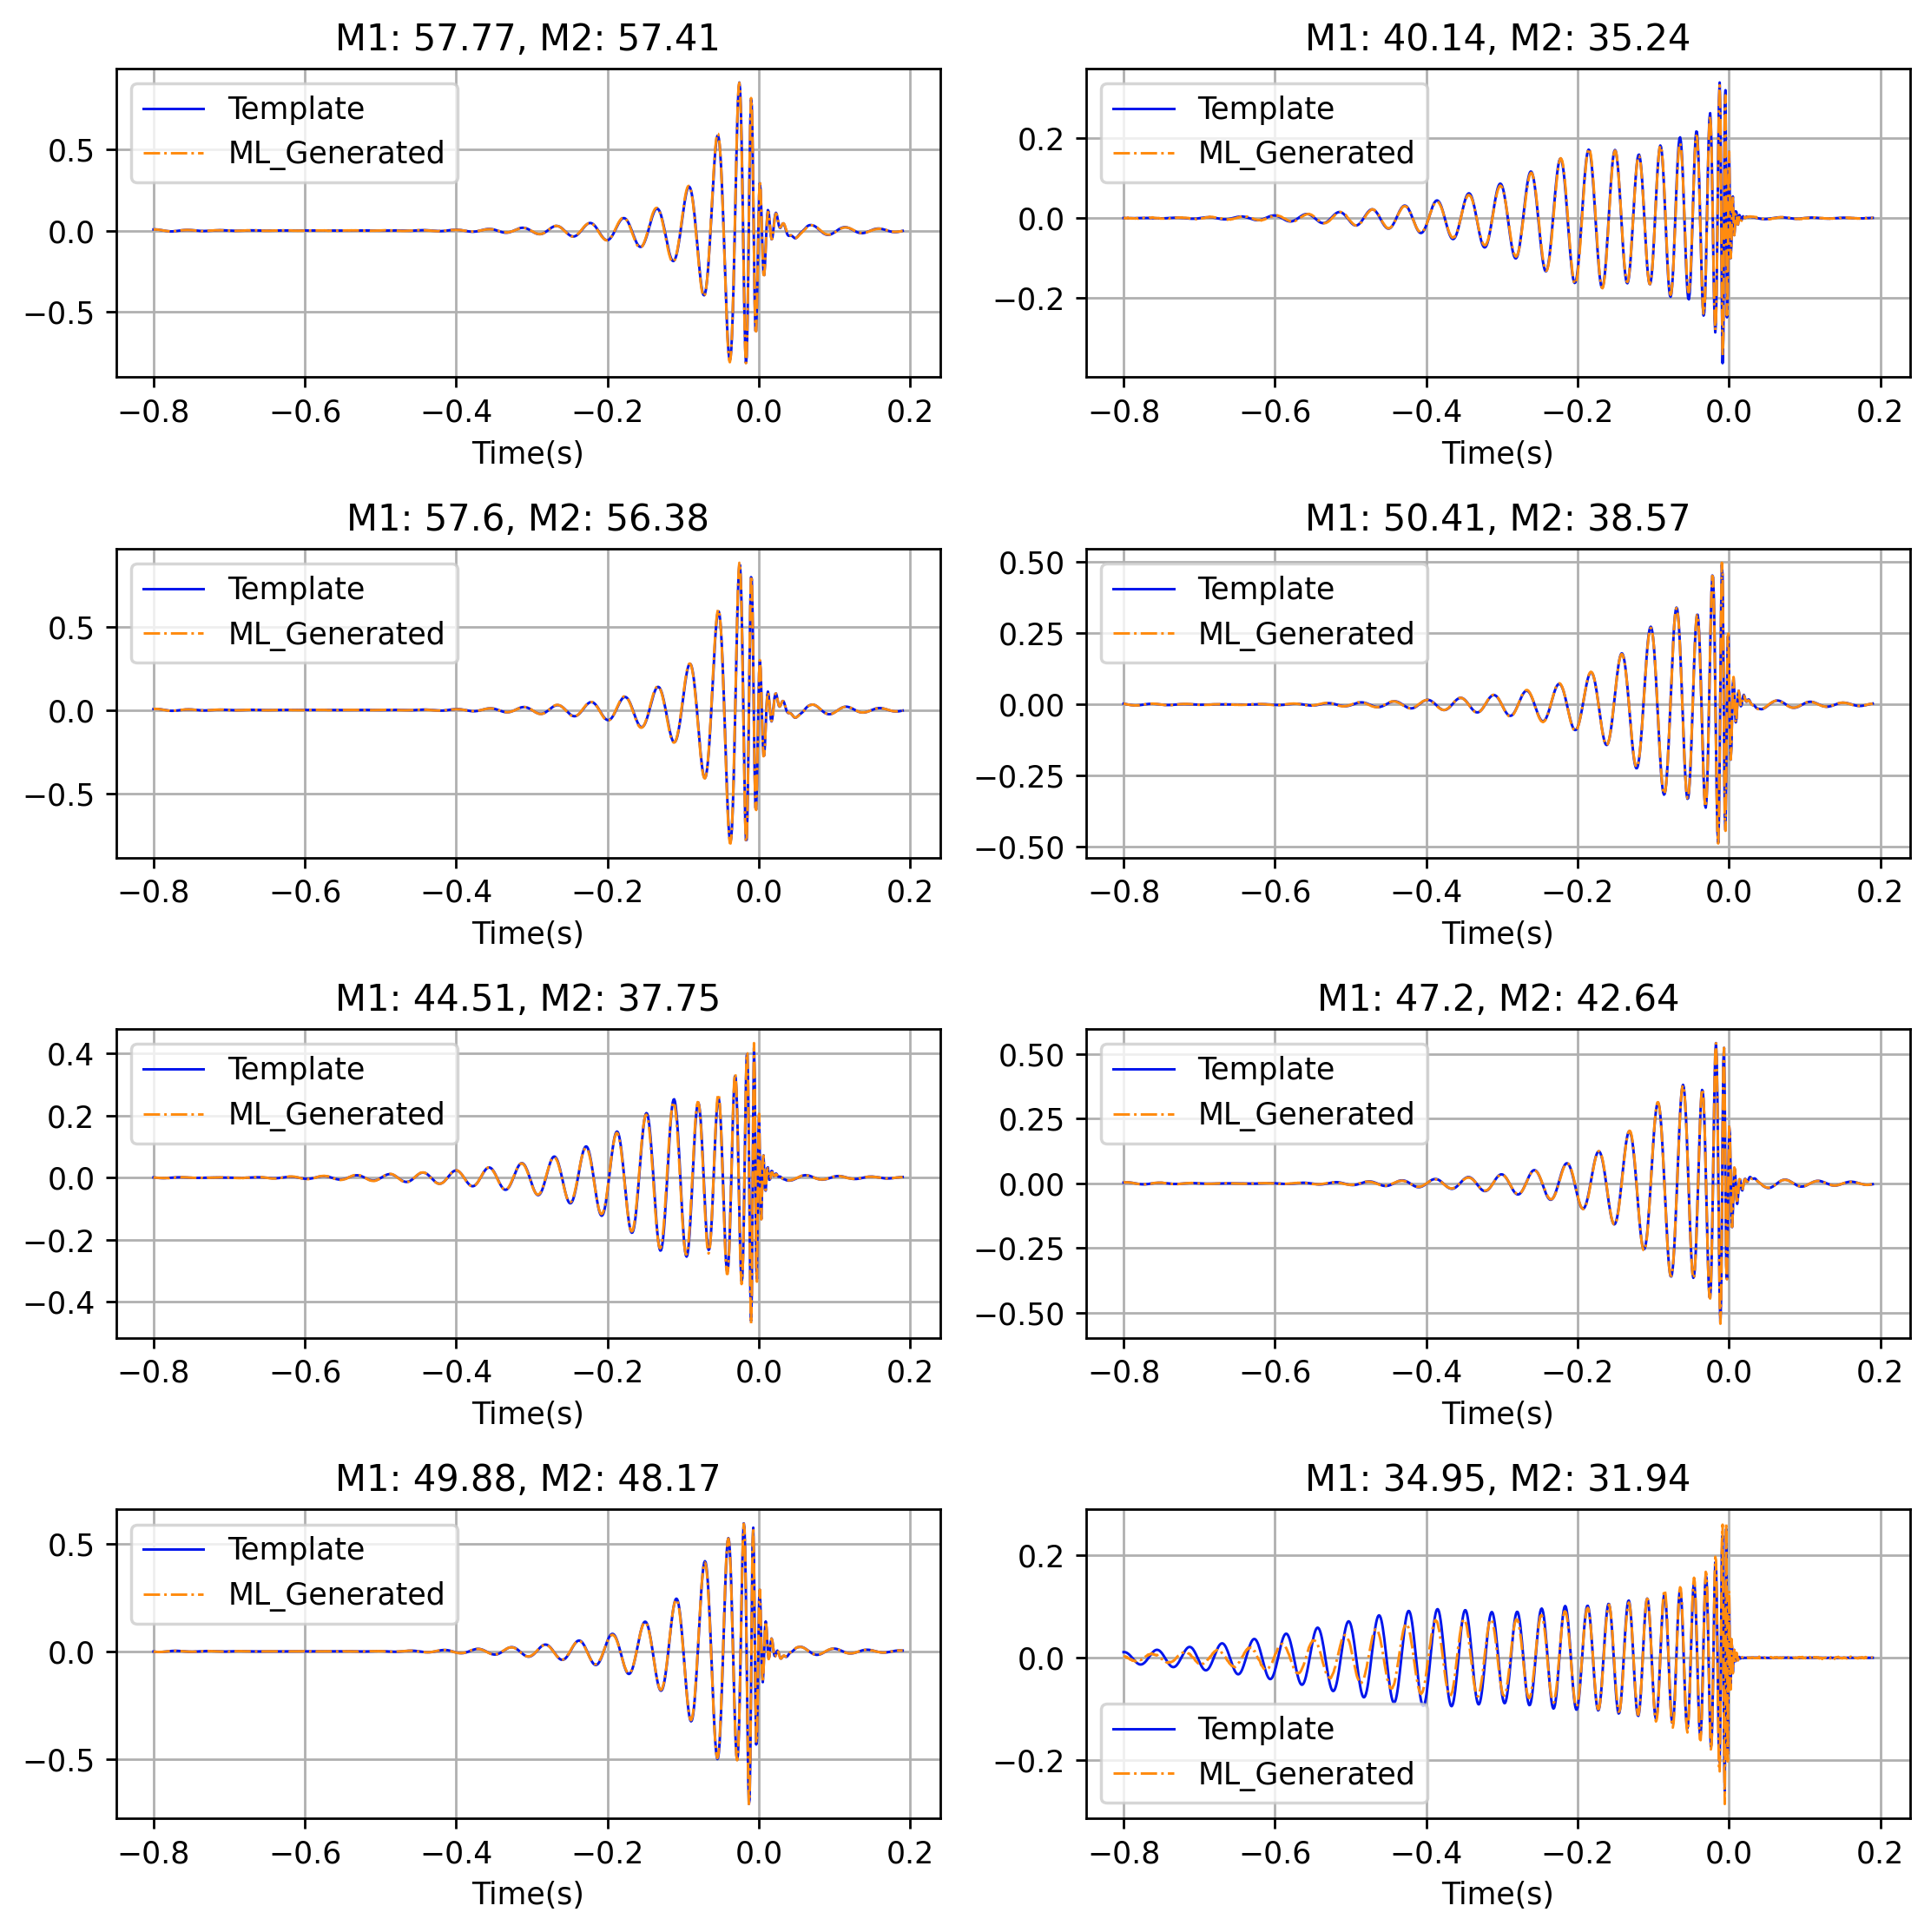

In [7]:
time  = np.linspace(-0.8, 0.19, 1024)

n_row, n_col = 4, 2
fig, ax = plt.subplots(n_row, n_col, figsize = (9, 9), dpi = 250, facecolor = 'white')
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].plot(time, test_strain[i + 4*j], color = '#0015ec', linewidth = 0.85, label = 'Template')
        ax[i, j].plot(time, jason[i + 4*j], linestyle = '-.', linewidth = 0.85, color = '#ff8b0f', label = 'ML_Generated')
        ax[i, j].grid()
        ax[i, j].legend()
        ax[i, j].set_title(f'This is the ({i + 1},{j + 1}) {i + 4 * j}block')
        ax[i, j].set_title(f'M1: {round(t_m_1[i + 4*j]*30 + 30, 2)}, M2: {round(t_m_2[i + 4*j]*30 + 30, 2)}')
        ax[i, j].set_xlabel('Time(s)')
plt.tight_layout()
# plt.savefig('30K_traing_data.png')
plt.show()

**Train Manually**

In [8]:
gym = NNcAE().gym(training_strain, para, validation_strain, v_para, n_t_data, n_v_data, auto_training = False)

KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='Strain', description="created by layer 'Strain'")


In [9]:
_, bobo_strain = gym.predict([test_strain, t_para])

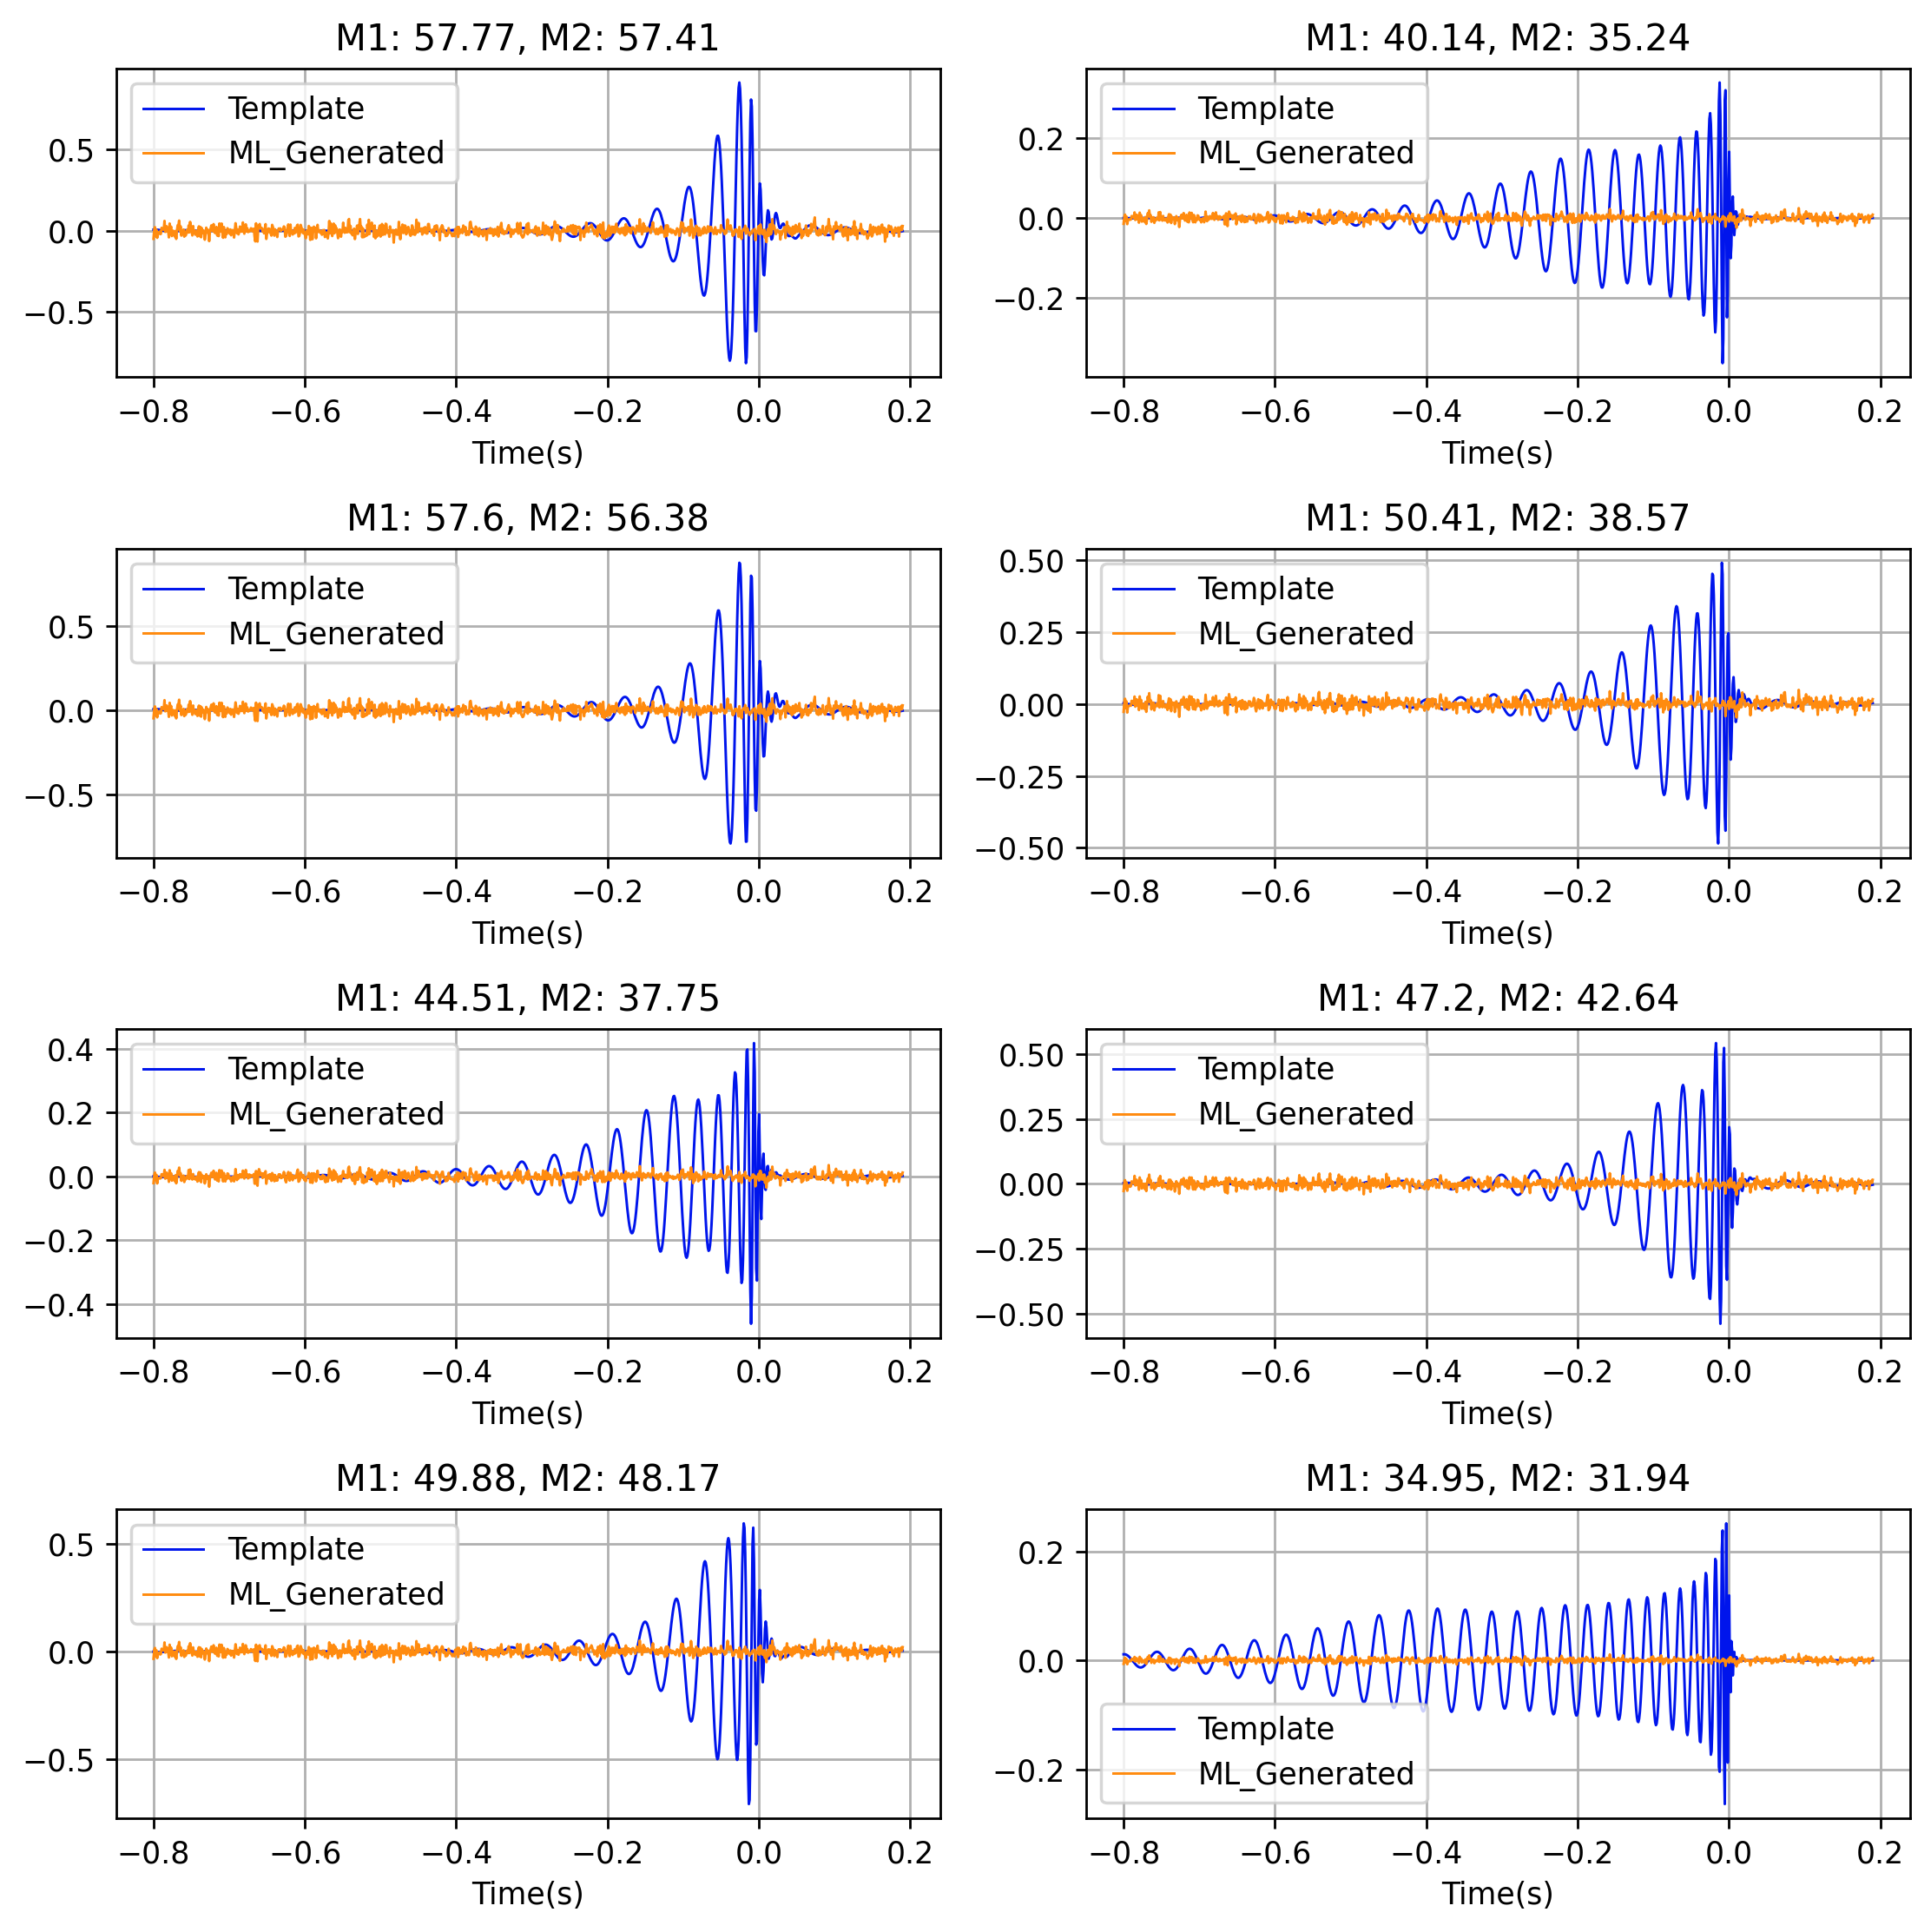

In [10]:
# Before training

time  = np.linspace(-0.8, 0.19, 1024)

n_row, n_col = 4, 2
fig, ax = plt.subplots(n_row, n_col, figsize = (9, 9), dpi = 250, facecolor = 'white')
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].plot(time, test_strain[i + 4*j], color = '#0015ec', linewidth = 0.85, label = 'Template')
        ax[i, j].plot(time, bobo_strain[i + 4*j], linestyle = '-', linewidth = 0.85, color = '#ff8b0f', label = 'ML_Generated')
        ax[i, j].grid()
        ax[i, j].legend()
        ax[i, j].set_title(f'M1: {round(t_m_1[i + 4*j]*30 + 30, 2)}, M2: {round(t_m_2[i + 4*j]*30 + 30, 2)}')
        ax[i, j].set_xlabel('Time(s)')
plt.tight_layout()
# plt.savefig('1K_traing_data.png')
plt.show()

In [11]:
zer0 = np.zeros(n_t_data).reshape([-1,1])
ziro = np.zeros(n_v_data).reshape([-1,1])

In [12]:
ghost = gym.fit(x = [training_strain, para], 
                y = [zer0, training_strain], 
                validation_data = ([validation_strain, v_para], 
                                   [ziro, validation_strain]),
                batch_size = 600, epochs = 500,)

Epoch 1/500
5/5 [==============================] - 1s 79ms/step - loss: 0.7552 - z_diff_loss: 0.7452 - Strain_loss: 0.0100 - z_diff_accuracy: 0.4721 - Strain_accuracy: 0.0632 - val_loss: 0.3887 - val_z_diff_loss: 0.3798 - val_Strain_loss: 0.0089 - val_z_diff_accuracy: 0.9200 - val_Strain_accuracy: 0.1633
Epoch 2/500
5/5 [==============================] - 0s 23ms/step - loss: 0.3346 - z_diff_loss: 0.3258 - Strain_loss: 0.0088 - z_diff_accuracy: 0.9625 - Strain_accuracy: 0.1344 - val_loss: 0.1599 - val_z_diff_loss: 0.1517 - val_Strain_loss: 0.0082 - val_z_diff_accuracy: 0.9967 - val_Strain_accuracy: 0.1167
Epoch 3/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1484 - z_diff_loss: 0.1400 - Strain_loss: 0.0084 - z_diff_accuracy: 0.9990 - Strain_accuracy: 0.1278 - val_loss: 0.1073 - val_z_diff_loss: 0.0994 - val_Strain_loss: 0.0079 - val_z_diff_accuracy: 1.0000 - val_Strain_accuracy: 0.1333
Epoch 4/500
5/5 [==============================] - 0s 22ms/step - loss: 0.1001 - z

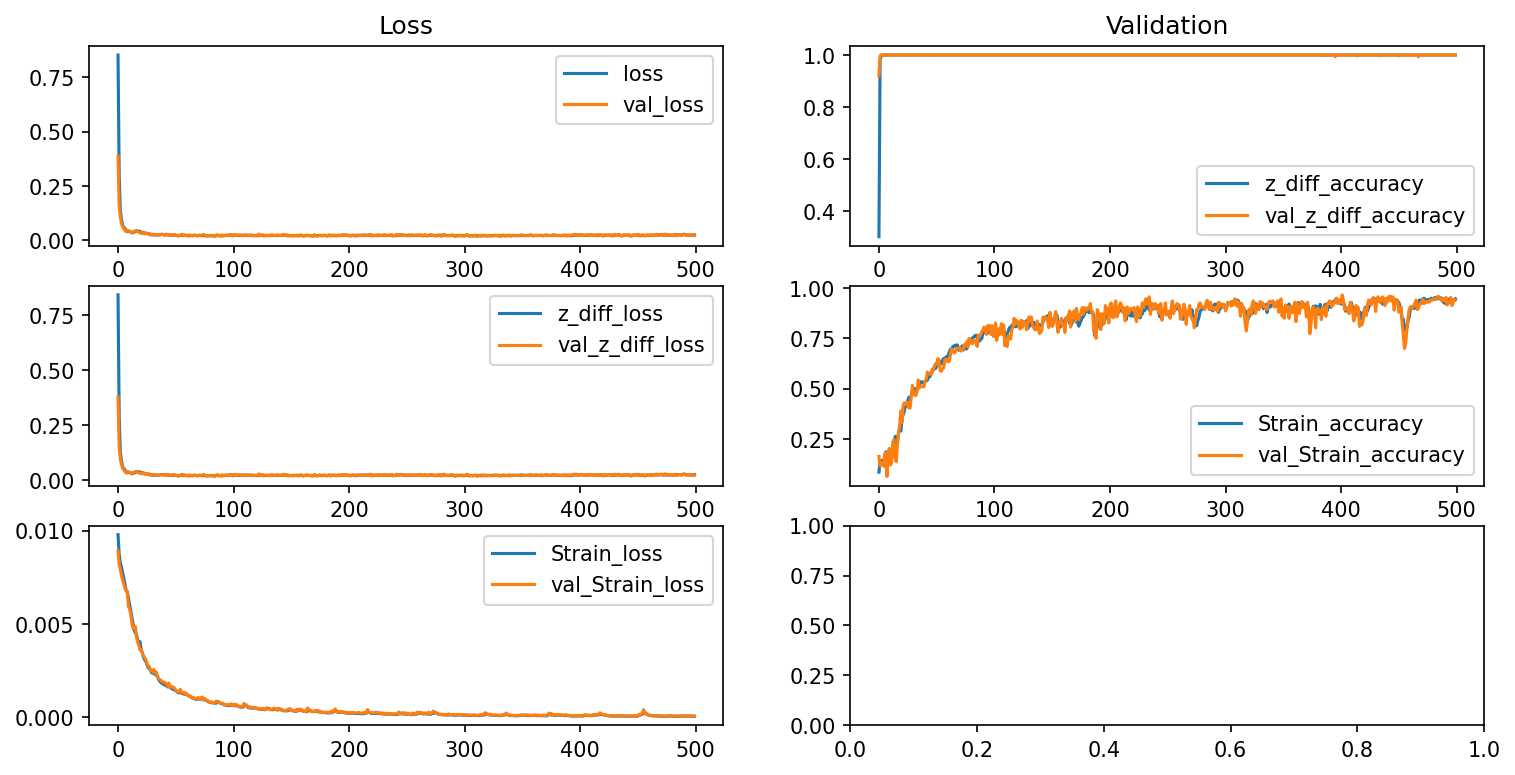

In [13]:
n_row, n_col = 3, 2
fig, ax = plt.subplots(n_row, n_col, figsize = (12, 6), dpi = 150, facecolor = 'white')
ax[0, 0].plot(ghost.history['loss'], label = 'loss')
ax[1, 0].plot(ghost.history['z_diff_loss'], label = 'z_diff_loss')
ax[2, 0].plot(ghost.history['Strain_loss'], label = 'Strain_loss')

ax[0, 0].plot(ghost.history['val_loss'], label = 'val_loss', linestyle = '-')
ax[1, 0].plot(ghost.history['val_z_diff_loss'], label = 'val_z_diff_loss', linestyle = '-')
ax[2, 0].plot(ghost.history['val_Strain_loss'], label = 'val_Strain_loss', linestyle = '-')

ax[0, 1].plot(ghost.history['z_diff_accuracy'], label = 'z_diff_accuracy')
ax[1, 1].plot(ghost.history['Strain_accuracy'], label = 'Strain_accuracy')
ax[0, 1].plot(ghost.history['val_z_diff_accuracy'], label = 'val_z_diff_accuracy')
ax[1, 1].plot(ghost.history['val_Strain_accuracy'], label = 'val_Strain_accuracy')
ax[0, 0].set_title('Loss')
ax[0, 1].set_title('Validation')
ax[1, 0].set_xlabel('epoch')
ax[0, 0].legend()
ax[1, 0].legend()
ax[2, 0].legend()
ax[0, 1].legend()
ax[1, 1].legend()
# ax[0, 0].legend()
plt.savefig('30K_model.png')
plt.show()

In [14]:
_, hoho_strain = gym.predict([test_strain, t_para])

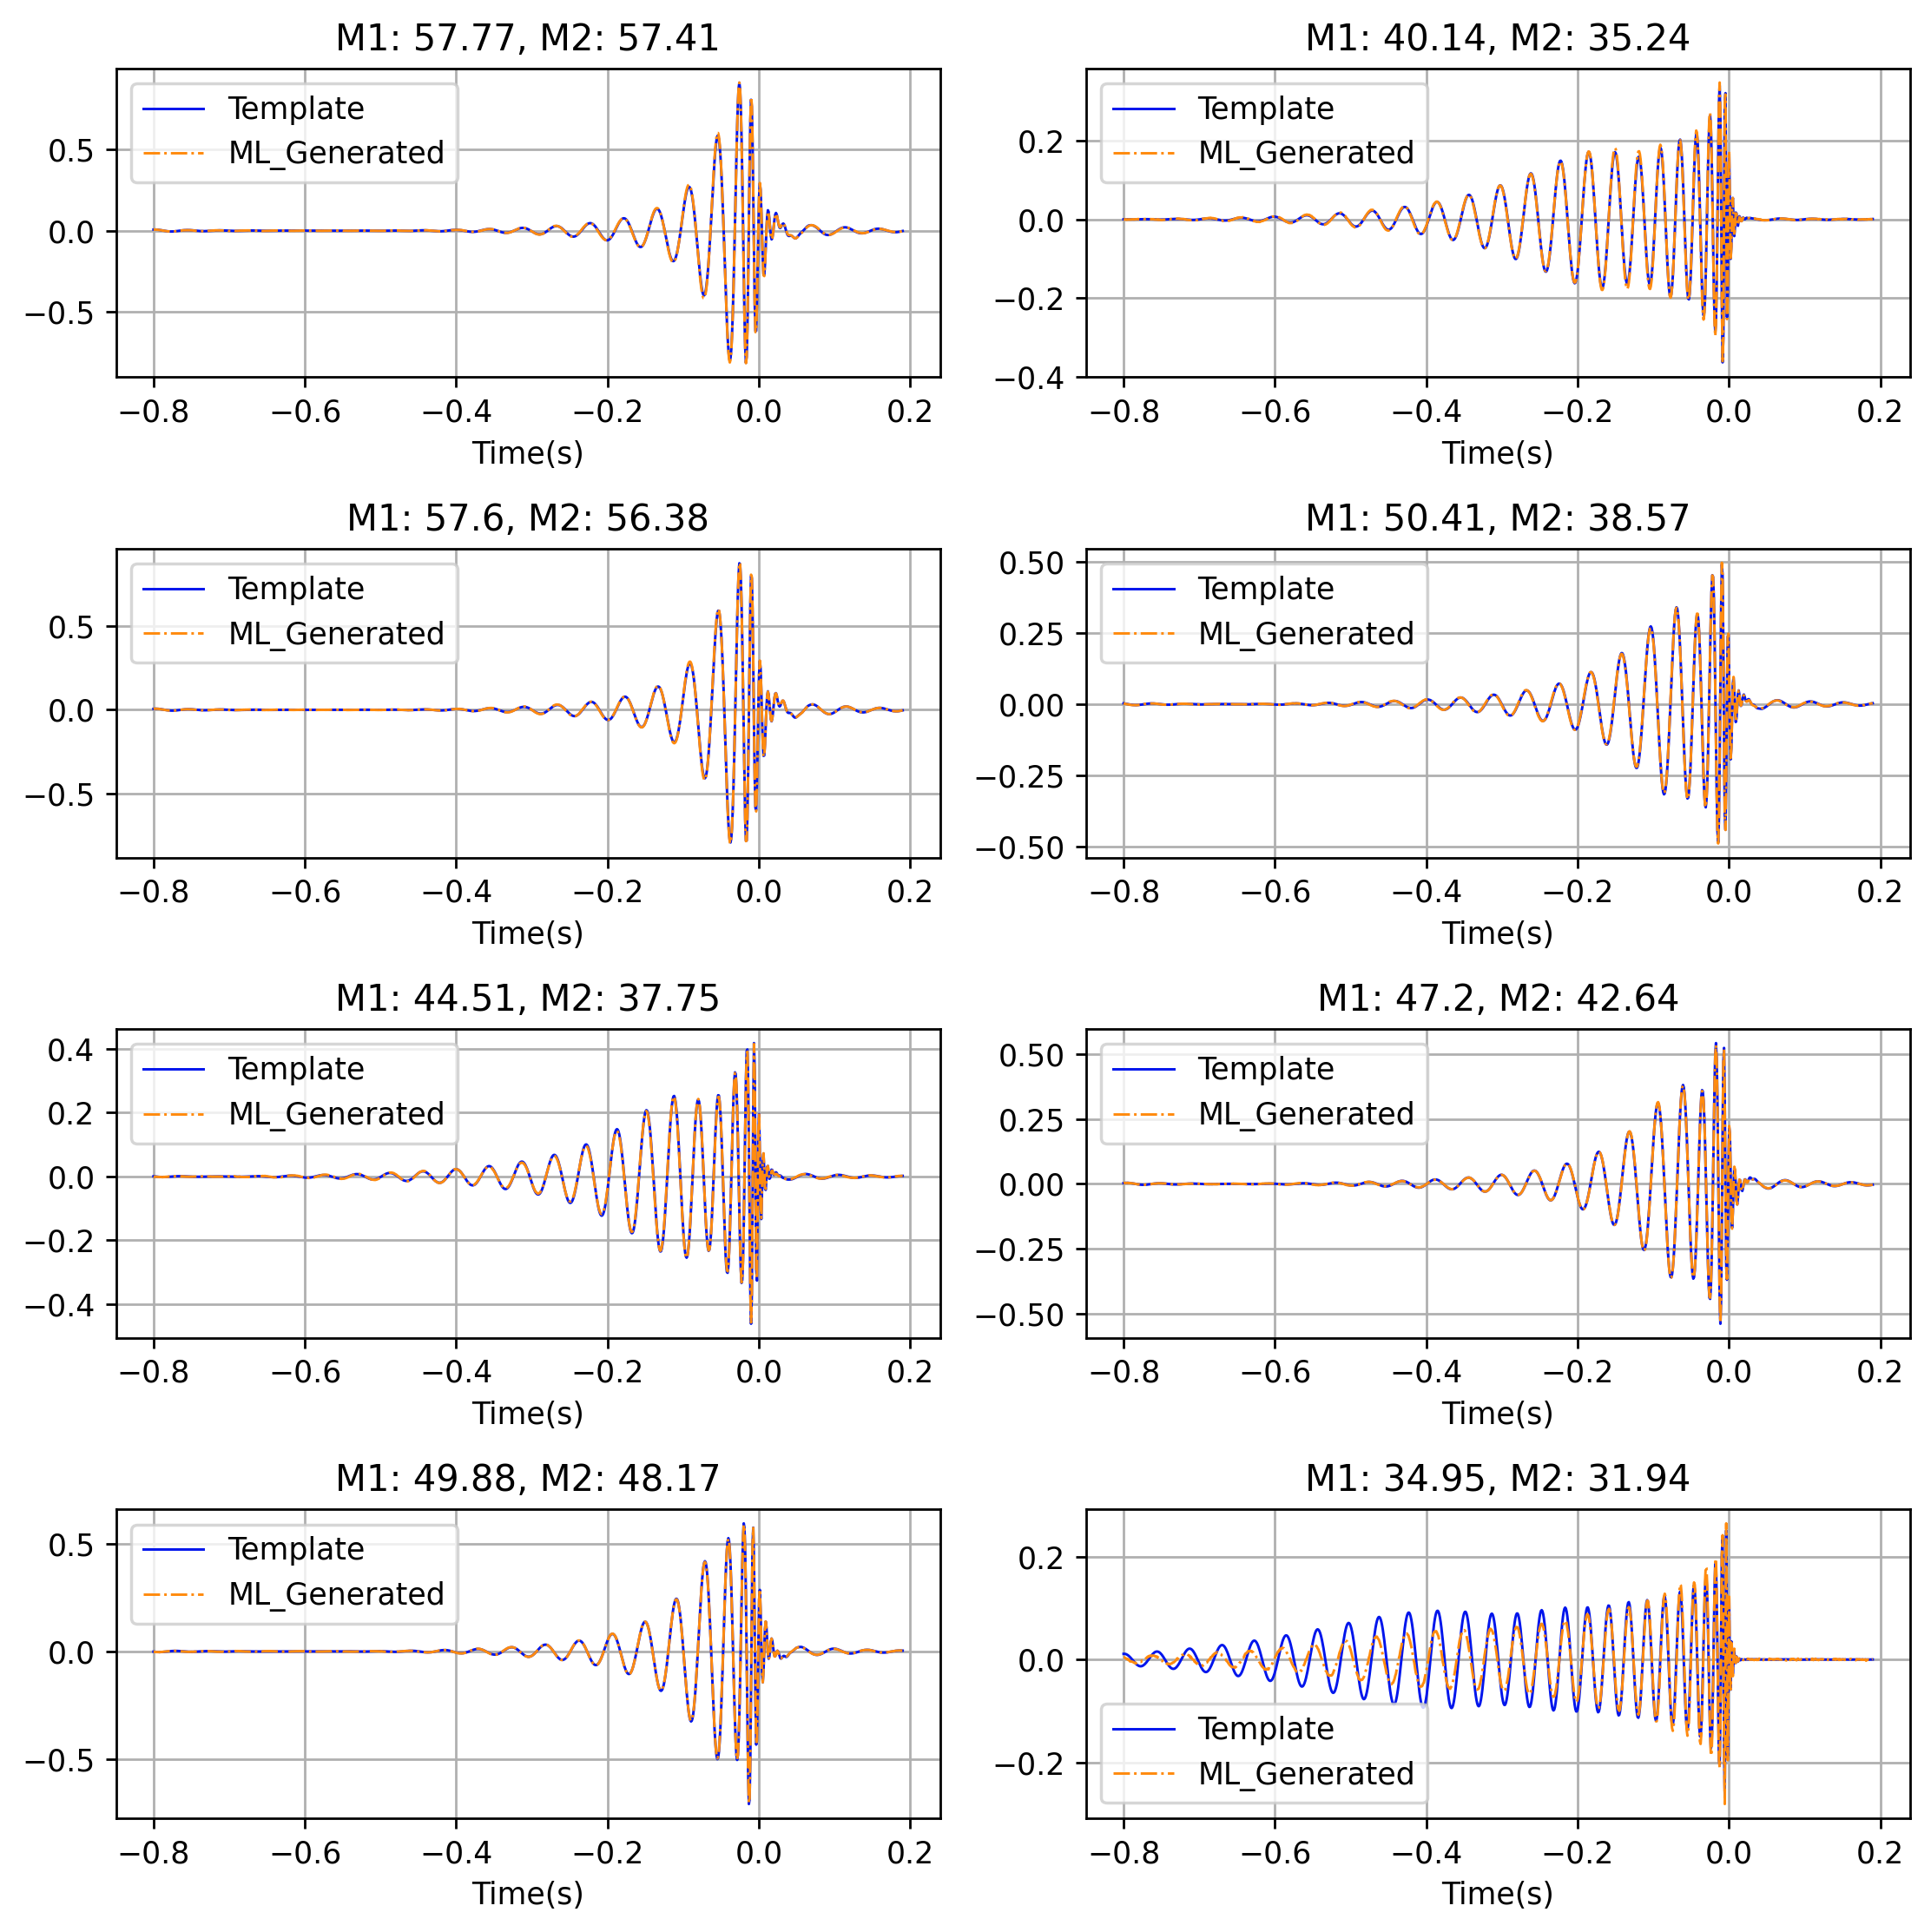

In [15]:
time  = np.linspace(-0.8, 0.19, 1024)

n_row, n_col = 4, 2
fig, ax = plt.subplots(n_row, n_col, figsize = (9, 9), dpi = 250, facecolor = 'white')
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].plot(time, test_strain[i + 4*j], color = '#0015ec', linewidth = 0.85, label = 'Template')
        ax[i, j].plot(time, hoho_strain[i + 4*j], linestyle = '-.', linewidth = 0.85, color = '#ff8b0f', label = 'ML_Generated')
        ax[i, j].grid()
        ax[i, j].legend()
        ax[i, j].set_title(f'This is the ({i + 1},{j + 1}) {i + 4 * j}block')
        ax[i, j].set_title(f'M1: {round(t_m_1[i + 4*j]*30 + 30, 2)}, M2: {round(t_m_2[i + 4*j]*30 + 30, 2)}')
        ax[i, j].set_xlabel('Time(s)')
plt.tight_layout()
# plt.savefig('30K_traing_data.png')
plt.show()